<a href="https://colab.research.google.com/github/deepsharma26/SIRT1_ML_NPASS/blob/main/Part6_QDA_and_XGB_with_sampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Here, we are applying two differet sampling stratigies (such as Undersampling, Random Over Sampling (ROS), with RandomforestClassifier, BAggingClassifier, QDA and XGBClassifier to handle the imablance datastet and enhancing the model performance

#1(a) RandomForestClassifier + ROS

Original dataset shape (full): Counter({0: 803, 1: 155})
Original training set shape (before ROS): Counter({0: 562, 1: 108})
Resampled training set shape (RandomOverSampler): Counter({0: 562, 1: 562})

Model: RandomForestClassifier (ROS - No additional sampling on test)
Accuracy: 0.7951388888888888
Balanced Accuracy: 0.7919572702392513
F1 Score: 0.556390977443609
Cohen's Kappa: 0.43772336201191253
Mean Absolute Error: 0.2048611111111111

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.80      0.87       241
           1       0.43      0.79      0.56        47

    accuracy                           0.80       288
   macro avg       0.69      0.79      0.71       288
weighted avg       0.87      0.80      0.82       288


Confusion Matrix:
 [[192  49]
 [ 10  37]]


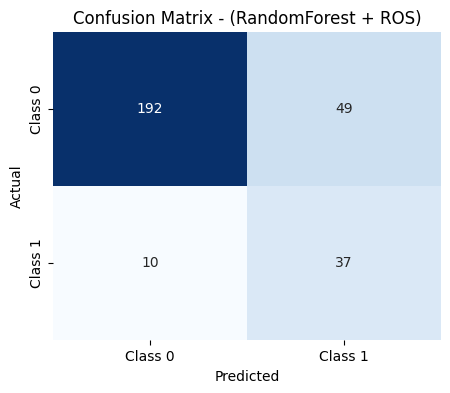

ROC AUC: 0.8554339189547099


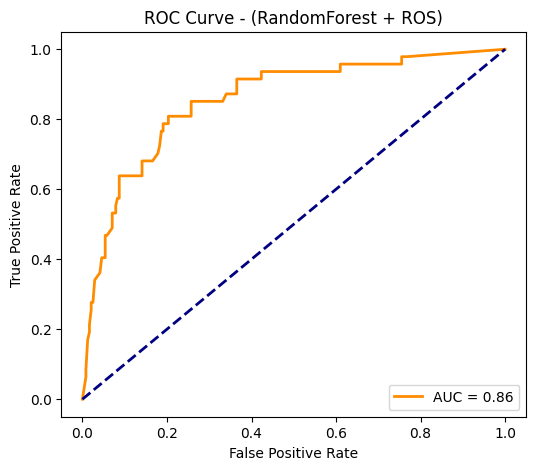


Stratified 10-Fold CV Accuracies (on resampled training data): [0.81415929 0.87610619 0.89380531 0.84955752 0.83035714 0.85714286
 0.84821429 0.91071429 0.91071429 0.78571429]
Mean Accuracy = 0.8576 ± 0.0390

Saved trained model to: RF_ROS_model.pkl


In [ ]:
#1(a) RandomForestClassifier + ROS


!pip install imbalanced-learn scikit-learn numpy pandas matplotlib seaborn xgboost --quiet

import pandas as pd
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, f1_score, cohen_kappa_score,
    mean_absolute_error, classification_report, confusion_matrix,
    roc_auc_score, roc_curve
)
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------
# 1. Load dataset
# -------------------------
df = pd.read_csv("/content/Final_Trainset_Top20.csv")
X = df.drop("BioactivityClass", axis=1)
y = df["BioactivityClass"]

# -------------------------
# 2. Create train/test split (keep original 'before' training set)
# -------------------------
# Split original data first so test set remains untouched by ROS
X_train_orig, X_test, y_train_orig, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Save Train set BEFORE ROS
train_before = pd.concat([X_train_orig.reset_index(drop=True),
                          pd.Series(y_train_orig, name="BioactivityClass").reset_index(drop=True)], axis=1)
train_before.to_csv("Trainset_Before_RF_ROS.csv", index=False)

# -------------------------
# 3. Apply RandomOverSampler to training data only
# -------------------------
ros = RandomOverSampler(random_state=42)
X_train_res, y_train_res = ros.fit_resample(X_train_orig, y_train_orig)

# Save Train set AFTER ROS
train_after = pd.concat([pd.DataFrame(X_train_res).reset_index(drop=True),
                         pd.Series(y_train_res, name="BioactivityClass").reset_index(drop=True)], axis=1)
train_after.to_csv("Trainset_After_RF_ROS.csv", index=False)

# Save Test set (untouched)
test_set = pd.concat([X_test.reset_index(drop=True),
                      pd.Series(y_test, name="BioactivityClass").reset_index(drop=True)], axis=1)
test_set.to_csv("RF_ROS_Testset.csv", index=False)

print("Original dataset shape (full):", Counter(y))
print("Original training set shape (before ROS):", Counter(y_train_orig))
print("Resampled training set shape (RandomOverSampler):", Counter(y_train_res))

# -------------------------
# 4. Scale features (fit on resampled training set)
# -------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

# -------------------------
# 5. Train RandomForestClassifier on resampled + scaled training set
# -------------------------
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train_res)

# -------------------------
# 6. Predict & Probabilities on the test set
# -------------------------
y_pred = rf_model.predict(X_test_scaled)

# If binary classification (2 classes) get proba for positive class, else None
y_proba = rf_model.predict_proba(X_test_scaled)[:, 1] if len(rf_model.classes_) == 2 else None

# -------------------------
# 7. Print metrics
# -------------------------
print("\nModel: RandomForestClassifier (ROS - No additional sampling on test)")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred, average='binary' if len(np.unique(y))==2 else 'macro'))
print("Cohen's Kappa:", cohen_kappa_score(y_test, y_pred))
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# -------------------------
# 8. Confusion matrix & heatmap
# -------------------------
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", cm)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=[f'Class {c}' for c in rf_model.classes_],
            yticklabels=[f'Class {c}' for c in rf_model.classes_])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - (RandomForest + ROS)")
plt.savefig("Confusion_matrix_RF_ROS.jpg", dpi=300, bbox_inches='tight')
plt.show()

# -------------------------
# 9. ROC AUC & curve (if binary)
# -------------------------
if y_proba is not None:
    roc_auc = roc_auc_score(y_test, y_proba)
    print("ROC AUC:", roc_auc)

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}', color='darkorange', lw=2)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--', lw=2)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve - (RandomForest + ROS)")
    plt.legend(loc="lower right")
    plt.savefig("ROC_RF_ROS.jpg", dpi=300, bbox_inches='tight')
    plt.show()

# -------------------------
# 10. Validation using StratifiedKFold on resampled training data
# -------------------------
from sklearn.model_selection import StratifiedKFold, cross_val_score

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Cross-validation using RandomForest on the resampled training data
cv_scores = cross_val_score(
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    X_train_res, y_train_res,
    cv=skf, scoring='accuracy'
)

print("\nStratified 10-Fold CV Accuracies (on resampled training data):", cv_scores)
print(f"Mean Accuracy = {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

# -------------------------
# 11. Saving trained model
# -------------------------
import pickle

model = rf_model  # keep name 'model' for familiarity with your original code
with open("RF_ROS_model.pkl", "wb") as file:
    pickle.dump(model, file)

print("\nSaved trained model to: RF_ROS_model.pkl")


#1(b) RandomoForestClassifier + Undersampling


Original dataset shape (full): Counter({0: 803, 1: 155})
Original training set shape (before undersampling): Counter({0: 562, 1: 108})
Resampled training set shape (RandomUnderSampler): Counter({0: 108, 1: 108})

Model: RandomForestClassifier (RandomUnderSampler)
Accuracy: 0.7013888888888888
Balanced Accuracy: 0.7701951090315176
F1 Score: 0.4880952380952381
Cohen's Kappa: 0.330775466090246
Mean Absolute Error: 0.2986111111111111

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.67      0.79       241
           1       0.34      0.87      0.49        47

    accuracy                           0.70       288
   macro avg       0.65      0.77      0.64       288
weighted avg       0.86      0.70      0.74       288


Confusion Matrix:
 [[161  80]
 [  6  41]]


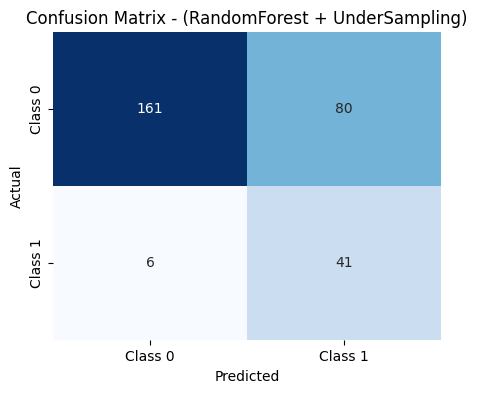

ROC AUC: 0.8507106912686502


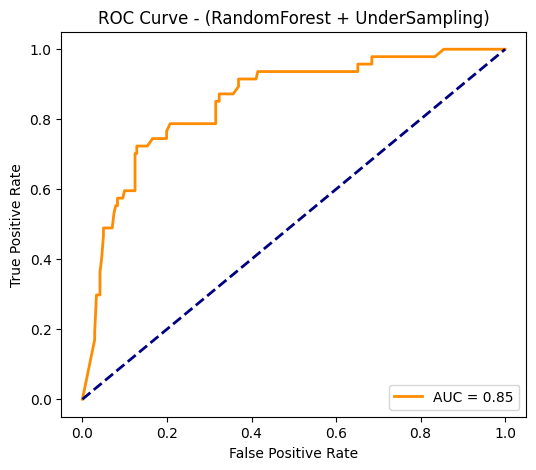


Stratified 10-Fold CV Accuracies (undersampled training data): [0.77272727 0.68181818 0.63636364 0.77272727 0.81818182 0.59090909
 0.61904762 0.80952381 0.80952381 0.76190476]
Mean Accuracy = 0.7273 ± 0.0823

Saved trained model to: RF_UNDER_model.pkl


In [ ]:
#1(b) RandomoForestClassifier + Undersampling

!pip install imbalanced-learn scikit-learn numpy pandas matplotlib seaborn xgboost --quiet

import pandas as pd
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, f1_score, cohen_kappa_score,
    mean_absolute_error, classification_report, confusion_matrix,
    roc_auc_score, roc_curve
)
# ---------------------- UNDER-SAMPLER IMPORT ----------------------
from imblearn.under_sampling import RandomUnderSampler
# -----------------------------------------------------------------
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------
# 1. Load dataset
# -------------------------
df = pd.read_csv("/content/Final_Trainset_Top20.csv")
X = df.drop("BioactivityClass", axis=1)
y = df["BioactivityClass"]

# -------------------------
# 2. Create train/test split (test set remains untouched)
# -------------------------
X_train_orig, X_test, y_train_orig, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Save Train set BEFORE undersampling
train_before = pd.concat([X_train_orig.reset_index(drop=True),
                          pd.Series(y_train_orig, name="BioactivityClass").reset_index(drop=True)], axis=1)
train_before.to_csv("Trainset_Before_RF_UNDER.csv", index=False)

# -------------------------
# 3. Apply RandomUnderSampler to training data only
# -------------------------
rus = RandomUnderSampler(random_state=42)
X_train_res, y_train_res = rus.fit_resample(X_train_orig, y_train_orig)

# Save Train set AFTER undersampling
train_after = pd.concat([pd.DataFrame(X_train_res).reset_index(drop=True),
                         pd.Series(y_train_res, name="BioactivityClass").reset_index(drop=True)], axis=1)
train_after.to_csv("Trainset_After_RF_UNDER.csv", index=False)

# Save Test set (untouched)
test_set = pd.concat([X_test.reset_index(drop=True),
                      pd.Series(y_test, name="BioactivityClass").reset_index(drop=True)], axis=1)
test_set.to_csv("RF_UNDER_Testset.csv", index=False)

print("Original dataset shape (full):", Counter(y))
print("Original training set shape (before undersampling):", Counter(y_train_orig))
print("Resampled training set shape (RandomUnderSampler):", Counter(y_train_res))

# -------------------------
# 4. Scale features (fit on undersampled training set)
# -------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

# -------------------------
# 5. Train RandomForestClassifier on resampled + scaled training set
# -------------------------
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train_res)

# -------------------------
# 6. Predict & Probabilities on test set
# -------------------------
y_pred = rf_model.predict(X_test_scaled)
y_proba = rf_model.predict_proba(X_test_scaled)[:, 1] if len(rf_model.classes_) == 2 else None

# -------------------------
# 7. Print metrics
# -------------------------
print("\nModel: RandomForestClassifier (RandomUnderSampler)")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred, average='binary' if len(np.unique(y))==2 else 'macro'))
print("Cohen's Kappa:", cohen_kappa_score(y_test, y_pred))
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# -------------------------
# 8. Confusion matrix
# -------------------------
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", cm)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=[f'Class {c}' for c in rf_model.classes_],
            yticklabels=[f'Class {c}' for c in rf_model.classes_])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - (RandomForest + UnderSampling)")
plt.savefig("Confusion_matrix_RF_UNDER.jpg", dpi=300, bbox_inches='tight')
plt.show()

# -------------------------
# 9. ROC (if binary)
# -------------------------
if y_proba is not None:
    roc_auc = roc_auc_score(y_test, y_proba)
    print("ROC AUC:", roc_auc)

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}', color='darkorange', lw=2)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--', lw=2)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve - (RandomForest + UnderSampling)")
    plt.legend(loc="lower right")
    plt.savefig("ROC_RF_UNDER.jpg", dpi=300, bbox_inches='tight')
    plt.show()

# -------------------------
# 10. Stratified 10-Fold CV on resampled training data
# -------------------------
from sklearn.model_selection import StratifiedKFold, cross_val_score

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

cv_scores = cross_val_score(
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    X_train_res, y_train_res,
    cv=skf, scoring='accuracy'
)

print("\nStratified 10-Fold CV Accuracies (undersampled training data):", cv_scores)
print(f"Mean Accuracy = {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

# -------------------------
# 11. Save trained model
# -------------------------
import pickle
model = rf_model
with open("RF_UNDER_model.pkl", "wb") as file:
    pickle.dump(model, file)

print("\nSaved trained model to: RF_UNDER_model.pkl")


#2(a) BaggingClassifier + ROS

Original dataset shape: (670, 20), (670,)
Resampled dataset shape: (1124, 20), (1124,)
Model: BaggingClassifier with Random OverSampling (ROS)
Accuracy: 0.7951388888888888
Balanced Accuracy: 0.7833936611635914
ROC AUC: 0.8534033724728525
F1 Score: 0.549618320610687
Cohen's Kappa: 0.43041029766693484
Mean Absolute Error: 0.2048611111111111

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.80      0.87       241
           1       0.43      0.77      0.55        47

    accuracy                           0.80       288
   macro avg       0.69      0.78      0.71       288
weighted avg       0.86      0.80      0.82       288



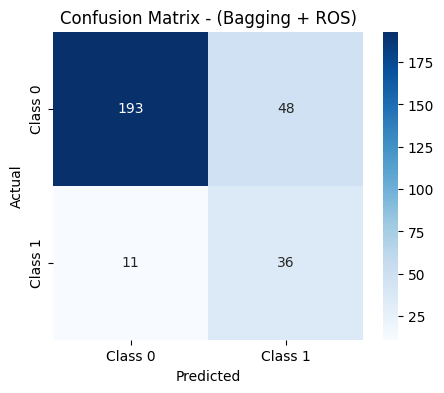

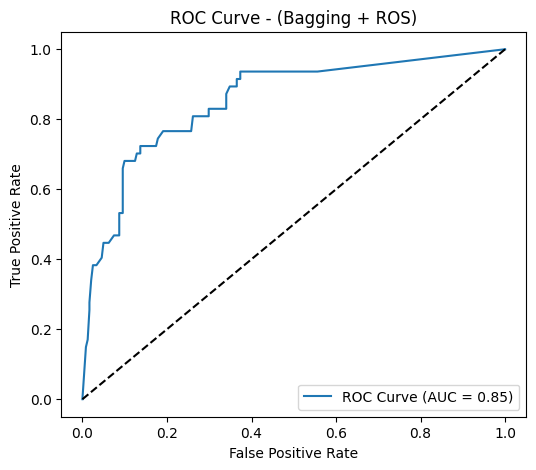

Stratified 10-Fold CV Accuracies: [0.81415929 0.87610619 0.88495575 0.84955752 0.83035714 0.85714286
 0.84821429 0.85714286 0.91071429 0.75      ]
Mean Accuracy = 0.8478 ± 0.0416


In [ ]:
#2(a) BaggingClassifier + ROS

!pip install matplotlib seaborn scikit-learn imbalanced-learn --quiet

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, roc_auc_score, f1_score,
    classification_report, confusion_matrix, cohen_kappa_score, mean_absolute_error,
    roc_curve
)
# ---------------------- CHANGED IMPORTS ----------------------
from sklearn.ensemble import BaggingClassifier
from imblearn.over_sampling import RandomOverSampler
# ------------------------------------------------------------
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv("/content/Final_Trainset_Top20.csv")

X = df.drop(["BioactivityClass"], axis=1)
y = df["BioactivityClass"]

if y.dtype == 'object':
    le = LabelEncoder()
    y = le.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# ---------------------- APPLY ROS TO TRAINING SET ----------------------
ros = RandomOverSampler(random_state=42)
X_train_res, y_train_res = ros.fit_resample(X_train, y_train)
# ----------------------------------------------------------------------

#saving the train and test set
#Save Train set BEFORE sampling
train_before = pd.concat([X_train.reset_index(drop=True),
                          pd.Series(y_train, name="BioactivityClass")], axis=1)
train_before.to_csv("Trainset_Before_Bagging_ROS.csv", index=False)

#Save Train set AFTER ROS
train_after = pd.concat([X_train_res,
                         pd.Series(y_train_res, name="BioactivityClass")], axis=1)
train_after.to_csv("Trainset_After_Bagging_ROS.csv", index=False)

#Save Test set
test_set = pd.concat([X_test.reset_index(drop=True),
                      pd.Series(y_test, name="BioactivityClass")], axis=1)
test_set.to_csv("Bagging_ROS_Testset.csv", index=False)

print(f"Original dataset shape: {X_train.shape}, {y_train.shape}")
print(f"Resampled dataset shape: {X_train_res.shape}, {y_train_res.shape}")

# ---------------------- CHANGED MODEL ----------------------
model = BaggingClassifier(random_state=42, n_jobs=-1)
# (default base estimator is DecisionTreeClassifier which supports predict_proba)
# ---------------------------------------------------------
model.fit(X_train_res, y_train_res)

y_pred = model.predict(X_test)
# predict_proba is available because base estimator supports it
y_prob = model.predict_proba(X_test)[:, 1]

print("Model: BaggingClassifier with Random OverSampling (ROS)")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))
print("F1 Score:", f1_score(y_test, y_pred))
print("Cohen's Kappa:", cohen_kappa_score(y_test, y_pred))
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1'],
            yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - (Bagging + ROS)')
plt.savefig("Confusion_matrix_Bagging_ROS.jpg", dpi=300, bbox_inches = 'tight')
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_prob):.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # random chance line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - (Bagging + ROS)')
plt.legend(loc='lower right')
plt.savefig("ROC_Bagging_ROS.jpg", dpi=300, bbox_inches = 'tight')
plt.show()

##Validation using StratifiedKFold for Bagging + ROS
from sklearn.model_selection import StratifiedKFold, cross_val_score
import numpy as np

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Cross-validation using Bagging on resampled training data
cv_scores = cross_val_score(
    BaggingClassifier(random_state=42, n_jobs=-1),
    X_train_res, y_train_res,  # resampled training data
    cv=skf, scoring='accuracy'
)

print("Stratified 10-Fold CV Accuracies:", cv_scores)
print(f"Mean Accuracy = {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

##Saving model
import pickle

# Save trained model
with open("Bagging_ROS_model.pkl", "wb") as file:
    pickle.dump(model, file)


#2(b). BaggingClaasifier + Undersampling

Original dataset shape: (670, 20), (670,)
Resampled dataset shape (UNDER): (216, 20), (216,)
Model: BaggingClassifier with Random Undersampling
Accuracy: 0.7152777777777778
Balanced Accuracy: 0.7699302551425797
ROC AUC: 0.8578176039551514
F1 Score: 0.49382716049382713
Cohen's Kappa: 0.34118172180996487
Mean Absolute Error: 0.2847222222222222

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.69      0.80       241
           1       0.35      0.85      0.49        47

    accuracy                           0.72       288
   macro avg       0.65      0.77      0.65       288
weighted avg       0.86      0.72      0.75       288



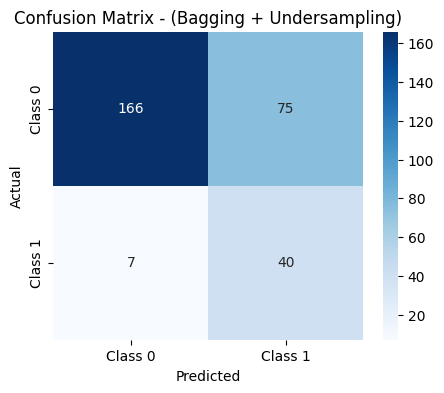

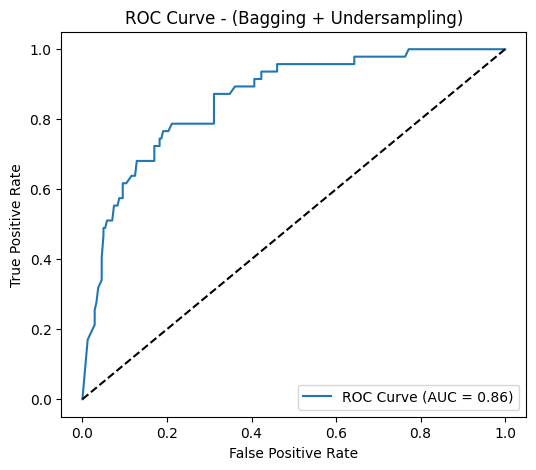

Stratified 10-Fold CV Accuracies: [0.77272727 0.72727273 0.63636364 0.81818182 0.72727273 0.68181818
 0.66666667 0.85714286 0.80952381 0.76190476]
Mean Accuracy = 0.7459 ± 0.0676

Saved trained model to: BAGGING_undersampling_model.pkl


In [ ]:
#2(b). BaggingClaasifier + Undersampling

!pip install matplotlib seaborn scikit-learn imbalanced-learn

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, roc_auc_score, f1_score,
    classification_report, confusion_matrix, cohen_kappa_score, mean_absolute_error,
    roc_curve
)
# ------------------------- CHANGED IMPORT -------------------------
from sklearn.ensemble import BaggingClassifier
# -----------------------------------------------------------------
from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import RandomUnderSampler


df = pd.read_csv("/content/Final_Trainset_Top20.csv")

X = df.drop(["BioactivityClass"], axis=1)
y = df["BioactivityClass"]

if y.dtype == 'object':
    le = LabelEncoder()
    y = le.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# ------------------------- UNDERSAMPLING -------------------------
rus = RandomUnderSampler(random_state=42)
X_train_res, y_train_res = rus.fit_resample(X_train, y_train)
# ----------------------------------------------------------------

# Save Train set BEFORE undersampling
train_before = pd.concat([X_train.reset_index(drop=True),
                          pd.Series(y_train, name="BioactivityClass")], axis=1)
train_before.to_csv("Trainset_Before_BAGGING_Undersampling.csv", index=False)

# Save Train set AFTER undersampling
train_after = pd.concat([X_train_res,
                         pd.Series(y_train_res, name="BioactivityClass")], axis=1)
train_after.to_csv("Trainset_After_BAGGING_Undersampling.csv", index=False)

# Save Test set
test_set = pd.concat([X_test.reset_index(drop=True),
                      pd.Series(y_test, name="BioactivityClass")], axis=1)
test_set.to_csv("BAGGING_undersampling_Testset.csv", index=False)

print(f"Original dataset shape: {X_train.shape}, {y_train.shape}")
print(f"Resampled dataset shape (UNDER): {X_train_res.shape}, {y_train_res.shape}")

# ------------------------- CHANGED MODEL -------------------------
model = BaggingClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)
# -----------------------------------------------------------------
model.fit(X_train_res, y_train_res)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("Model: BaggingClassifier with Random Undersampling")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))
print("F1 Score:", f1_score(y_test, y_pred))
print("Cohen's Kappa:", cohen_kappa_score(y_test, y_pred))
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# ------------------------- CONFUSION MATRIX -------------------------
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1'],
            yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - (Bagging + Undersampling)')
plt.savefig("Confusion_matrix_BAGGING_undersampling.jpg", dpi=300, bbox_inches='tight')
plt.show()

# ------------------------- ROC CURVE -------------------------
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_prob):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - (Bagging + Undersampling)')
plt.legend(loc='lower right')
plt.savefig("ROC_BAGGING_Undersampling.jpg", dpi=300, bbox_inches='tight')
plt.show()

# ------------------------- STRATIFIED KFOLD CV -------------------------
from sklearn.model_selection import StratifiedKFold, cross_val_score
import numpy as np

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

cv_scores = cross_val_score(
    BaggingClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    X_train_res, y_train_res,
    cv=skf, scoring='accuracy'
)

print("Stratified 10-Fold CV Accuracies:", cv_scores)
print(f"Mean Accuracy = {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

# ------------------------- SAVE MODEL -------------------------
import pickle
with open("BAGGING_undersampling_model.pkl", "wb") as file:
    pickle.dump(model, file)

print("\nSaved trained model to: BAGGING_undersampling_model.pkl")


#3(a) QDA + ROS

Original dataset shape: Counter({0: 803, 1: 155})

Resampled shape (ROSE-style): Counter({1: 803, 0: 803})

Accuracy: 0.8195020746887967
Balanced Accuracy: 0.8195020746887967
F1 Score: 0.8087912087912088
Cohen's Kappa: 0.6390041493775933
Mean Absolute Error: 0.18049792531120332

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.88      0.83       241
           1       0.86      0.76      0.81       241

    accuracy                           0.82       482
   macro avg       0.82      0.82      0.82       482
weighted avg       0.82      0.82      0.82       482


Confusion Matrix:
 [[211  30]
 [ 57 184]]


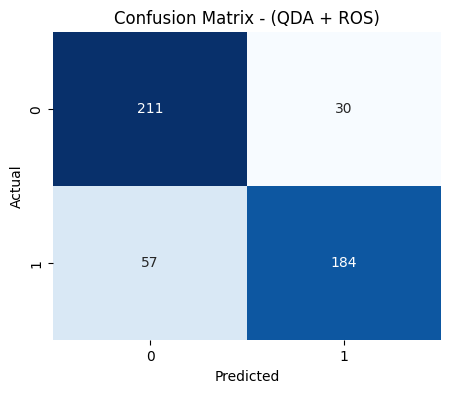

ROC AUC: 0.909135517639159


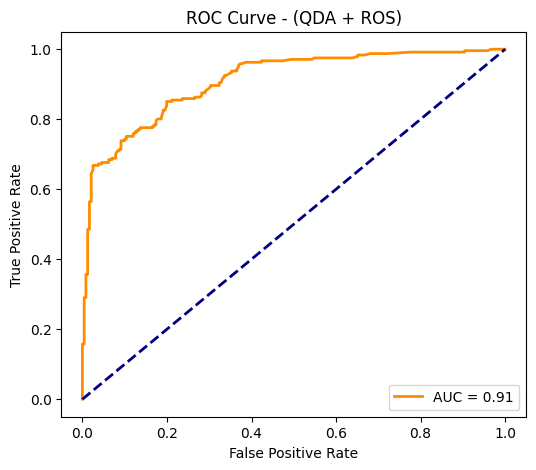

Stratified 10-Fold CV Accuracies: [0.72727273 0.77272727 0.68181818 0.72727273 0.72727273 0.68181818
 0.71428571 0.9047619  0.66666667 0.71428571]
Mean Accuracy = 0.7318 ± 0.0644


In [ ]:
#3(a) QDA + ROS

!pip install imbalanced-learn scikit-learn numpy pandas matplotlib seaborn

import pandas as pd
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, f1_score, cohen_kappa_score,
    mean_absolute_error, classification_report, confusion_matrix,
    roc_auc_score, roc_curve
)
from imblearn.over_sampling import SMOTE, RandomOverSampler
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("/content/Final_Trainset_Top20.csv")
X = df.drop("BioactivityClass", axis=1)
y = df["BioactivityClass"]

print("Original dataset shape:", Counter(y))

ros = RandomOverSampler(shrinkage=0.1, random_state=42)
X_ros, y_ros = ros.fit_resample(X, y)

#saving the train and test set
#Save Train set BEFORE ROS sampling
train_before = pd.concat([X_train.reset_index(drop=True),
                          pd.Series(y_train, name="BioactivityClass")], axis=1)
train_before.to_csv("Trainset_Before_QDA_ROS.csv", index=False)

#Save Train set AFTER ROS sampling
train_after = pd.concat([X_train_res,
                         pd.Series(y_train_res, name="BioactivityClass")], axis=1)
train_after.to_csv("Trainset_After_QDA_ROS.csv", index=False)

#Save Test set
test_set = pd.concat([X_test.reset_index(drop=True),
                      pd.Series(y_test, name="BioactivityClass")], axis=1)
test_set.to_csv("QDA_ROS_Testset.csv", index=False)


print("\nResampled shape (ROSE-style):", Counter(y_ros))

X_train, X_test, y_train, y_test = train_test_split(
    X_ros, y_ros, test_size=0.3, random_state=42, stratify=y_ros
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train_scaled, y_train)


y_pred = qda.predict(X_test_scaled)
y_proba = qda.predict_proba(X_test_scaled)[:, 1] if len(qda.classes_) == 2 else None


print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Cohen's Kappa:", cohen_kappa_score(y_test, y_pred))
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", cm)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - (QDA + ROS)")
plt.savefig("Confusion_matrix_QDA_ROS_sampling.jpg", dpi=300, bbox_inches = 'tight')
plt.show()



if y_proba is not None:
    roc_auc = roc_auc_score(y_test, y_proba)
    print("ROC AUC:", roc_auc)

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}', color='darkorange', lw=2)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--', lw=2)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve - (QDA + ROS)")
    plt.legend(loc="lower right")
    plt.savefig("ROC_QDA_ROS.jpg", dpi=300, bbox_inches = 'tight')
    plt.show()


##Validation using StratifiedKFold for QDA + ROS
from sklearn.model_selection import StratifiedKFold, cross_val_score
import numpy as np

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Cross-validation using QDA + ROS
cv_scores = cross_val_score(
    QuadraticDiscriminantAnalysis(),
    X_train_res, y_train_res,  # resampled training data
    cv=skf, scoring='accuracy'
)

print("Stratified 10-Fold CV Accuracies:", cv_scores)
print(f"Mean Accuracy = {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")


##Saving model
import pickle

# Save trained model
with open("QDA_ROS_model.pkl", "wb") as file:
    pickle.dump(model, file)


#3(b). QDA + Undersampling


Original dataset shape: (670, 20), (670,)
Resampled dataset shape: (216, 20), (216,)
Model: Quadratic Discriminant Analysis with Random Undersampling
Accuracy: 0.7534722222222222
Balanced Accuracy: 0.7499337865277655
ROC AUC: 0.8295665224684382
F1 Score: 0.49645390070921985
Cohen's Kappa: 0.35641445297746455
Mean Absolute Error: 0.2465277777777778

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.76      0.84       241
           1       0.37      0.74      0.50        47

    accuracy                           0.75       288
   macro avg       0.66      0.75      0.67       288
weighted avg       0.85      0.75      0.78       288



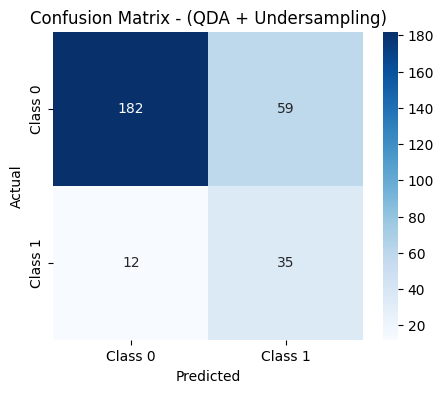

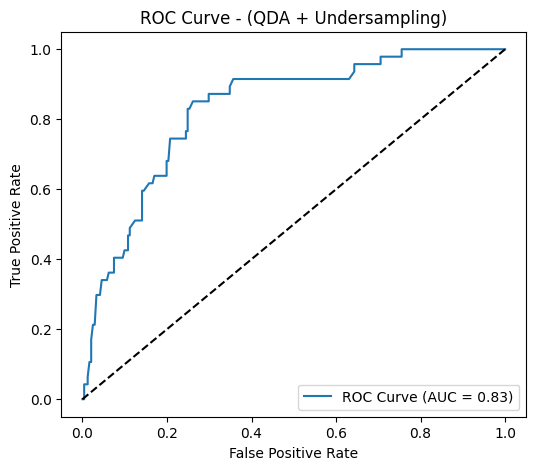

Stratified 10-Fold CV Accuracies: [0.72727273 0.77272727 0.68181818 0.72727273 0.72727273 0.68181818
 0.71428571 0.9047619  0.66666667 0.71428571]
Mean Accuracy = 0.7318 ± 0.0644


In [ ]:
#3(b). QDA + Undersampling

!pip install matplotlib seaborn scikit-learn imbalanced-learn

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, roc_auc_score, f1_score,
    classification_report, confusion_matrix, cohen_kappa_score, mean_absolute_error,
    roc_curve
)
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import RandomUnderSampler


df = pd.read_csv("/content/Final_Trainset_Top20.csv")


X = df.drop(["BioactivityClass"], axis=1)
y = df["BioactivityClass"]


if y.dtype == 'object':
    le = LabelEncoder()
    y = le.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)


rus = RandomUnderSampler(random_state=42)
X_train_res, y_train_res = rus.fit_resample(X_train, y_train)

#saving the train and test set
#Save Train set BEFORE sampling
train_before = pd.concat([X_train.reset_index(drop=True),
                          pd.Series(y_train, name="BioactivityClass")], axis=1)
train_before.to_csv("Trainset_Before_QDA_Undersampling.csv", index=False)

#Save Train set AFTER undersampling
train_after = pd.concat([X_train_res,
                         pd.Series(y_train_res, name="BioactivityClass")], axis=1)
train_after.to_csv("Trainset_After_QDA_Undersampling.csv", index=False)

#Save Test set
test_set = pd.concat([X_test.reset_index(drop=True),
                      pd.Series(y_test, name="BioactivityClass")], axis=1)
test_set.to_csv("QDA_undersampling_Testset.csv", index=False)


print(f"Original dataset shape: {X_train.shape}, {y_train.shape}")
print(f"Resampled dataset shape: {X_train_res.shape}, {y_train_res.shape}")

model = QuadraticDiscriminantAnalysis()
model.fit(X_train_res, y_train_res)


y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]


print("Model: Quadratic Discriminant Analysis with Random Undersampling")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))
print("F1 Score:", f1_score(y_test, y_pred))
print("Cohen's Kappa:", cohen_kappa_score(y_test, y_pred))
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1'],
            yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - (QDA + Undersampling)')
plt.savefig("Confusion_matrix_QDA_undersampling.jpg", dpi=300, bbox_inches = 'tight')
plt.show()


fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_prob):.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # random chance line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - (QDA + Undersampling)')
plt.legend(loc='lower right')
plt.savefig("ROC_QDA_Undersampling.jpg", dpi=300, bbox_inches = 'tight')
plt.show()


##Validation using StratifiedKFold for QDA + undersampling
from sklearn.model_selection import StratifiedKFold, cross_val_score
import numpy as np

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Cross-validation using QDA + UnderSampling
cv_scores = cross_val_score(
    QuadraticDiscriminantAnalysis(),
    X_train_res, y_train_res,  # resampled training data
    cv=skf, scoring='accuracy'
)

print("Stratified 10-Fold CV Accuracies:", cv_scores)
print(f"Mean Accuracy = {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")


##Saving model
import pickle

# Save trained model
with open("QDA_undersampling_model.pkl", "wb") as file:
    pickle.dump(model, file)


#4(a) XGBClassifier + ROS

Original dataset shape: Counter({0: 803, 1: 155})
Resampled dataset shape (RandomOverSampler): Counter({1: 803, 0: 803})


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:11:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Accuracy: 0.8651452282157677
Balanced Accuracy: 0.8651452282157677
F1 Score: 0.8625792811839323
Cohen's Kappa: 0.7302904564315353
Mean Absolute Error: 0.13485477178423236

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.88      0.87       241
           1       0.88      0.85      0.86       241

    accuracy                           0.87       482
   macro avg       0.87      0.87      0.87       482
weighted avg       0.87      0.87      0.87       482


Confusion Matrix:
 [[213  28]
 [ 37 204]]


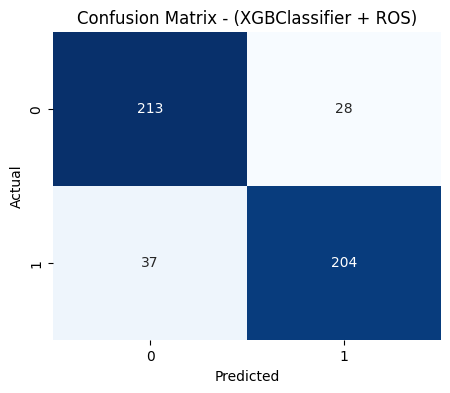

ROC AUC: 0.9332053511475353


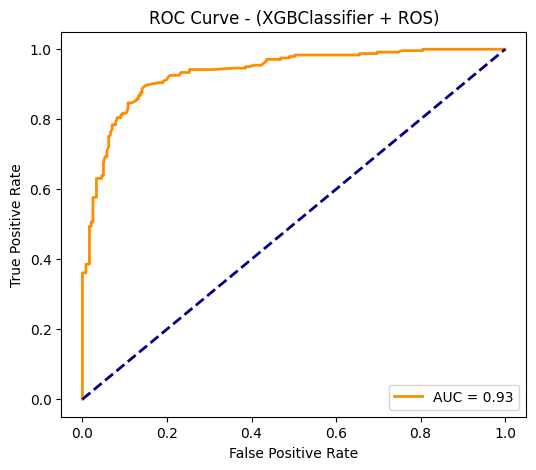

Stratified 10-Fold CV Accuracies: [0.77272727 0.72727273 0.63636364 0.72727273 0.77272727 0.63636364
 0.61904762 0.80952381 0.76190476 0.80952381]
Mean Accuracy = 0.7273 ± 0.0686


In [ ]:
#4(a) XGBClassifier + ROS

!pip install imbalanced-learn scikit-learn numpy pandas matplotlib seaborn xgboost

import pandas as pd
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, f1_score, cohen_kappa_score,
    mean_absolute_error, classification_report, confusion_matrix,
    roc_auc_score, roc_curve
)
from imblearn.over_sampling import RandomOverSampler
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv("/content/Final_Trainset_Top20.csv")
X = df.drop("BioactivityClass", axis=1)
y = df["BioactivityClass"]

X_train, X_test, y_train, y_test = train_test_split(
    X_ros, y_ros, test_size=0.3, random_state=42, stratify=y_ros
)
ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X, y)

#saving the train and test set
#Save Train set BEFORE XGB + ROS
train_before = pd.concat([X_train.reset_index(drop=True),
                          pd.Series(y_train, name="BioactivityClass")], axis=1)
train_before.to_csv("Trainset_Before_XGB_ROS.csv", index=False)

#Save Train set AFTER XGB + ROS
train_after = pd.concat([X_train_res,
                         pd.Series(y_train_res, name="BioactivityClass")], axis=1)
train_after.to_csv("Trainset_After_XGB_ROS.csv", index=False)

#Save Test set
test_set = pd.concat([X_test.reset_index(drop=True),
                      pd.Series(y_test, name="BioactivityClass")], axis=1)
test_set.to_csv("XGB_ROS_Testset.csv", index=False)

print("Original dataset shape:", Counter(y))
print("Resampled dataset shape (RandomOverSampler):", Counter(y_ros))


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


xgb_model = XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)
xgb_model.fit(X_train_scaled, y_train)


y_pred = xgb_model.predict(X_test_scaled)
y_proba = xgb_model.predict_proba(X_test_scaled)[:, 1] if len(xgb_model.classes_) == 2 else None


print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Cohen's Kappa:", cohen_kappa_score(y_test, y_pred))
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", cm)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - (XGBClassifier + ROS)")
plt.savefig("Confusion_matrix_XGB_ROS.jpg", dpi=300, bbox_inches = 'tight')
plt.show()


if y_proba is not None:
    roc_auc = roc_auc_score(y_test, y_proba)
    print("ROC AUC:", roc_auc)

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}', color='darkorange', lw=2)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--', lw=2)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve - (XGBClassifier + ROS)")
    plt.legend(loc="lower right")
    plt.savefig("ROC_XGB_ROS.jpg", dpi=300, bbox_inches = 'tight')
    plt.show()

##Validation using StratifiedKFold for XGB + ROS
from sklearn.model_selection import StratifiedKFold, cross_val_score
import numpy as np

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Cross-validation using XGB + ROS
cv_scores = cross_val_score(
    XGBClassifier(),
    X_train_res, y_train_res,  # resampled training data
    cv=skf, scoring='accuracy'
)

print("Stratified 10-Fold CV Accuracies:", cv_scores)
print(f"Mean Accuracy = {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")


##Saving model
import pickle

# Save trained model
with open("XGB_ROS_model.pkl", "wb") as file:
    pickle.dump(model, file)


#4(b) XGBClassifier + Undersampling

Original dataset shape: (670, 20), (670,)
Resampled dataset shape: (216, 20), (216,)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:12:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Model: XGBClassifier with Undersampling
Accuracy: 0.7430555555555556
Balanced Accuracy: 0.7950913745916837
ROC AUC: 0.8412200935817075
F1 Score: 0.5256410256410257
Cohen's Kappa: 0.38550256617265444
Mean Absolute Error: 0.2569444444444444

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.72      0.82       241
           1       0.38      0.87      0.53        47

    accuracy                           0.74       288
   macro avg       0.67      0.80      0.67       288
weighted avg       0.87      0.74      0.78       288



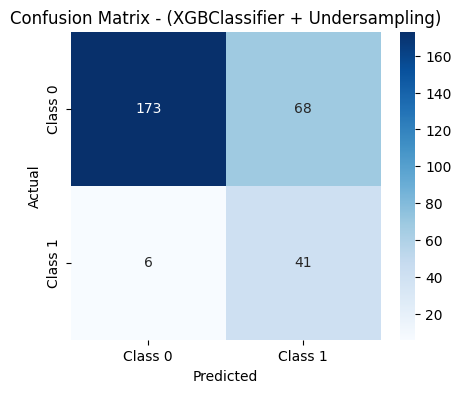

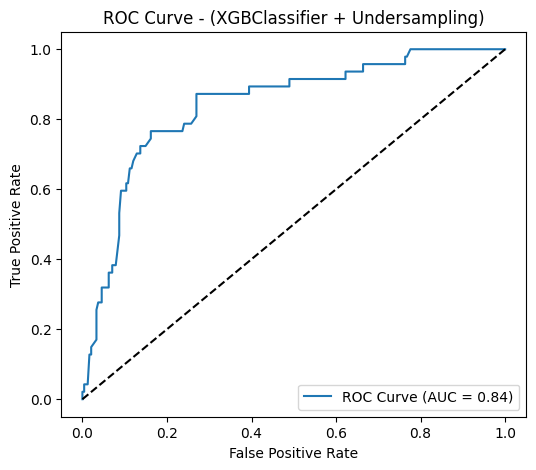

Stratified 10-Fold CV Accuracies: [0.77272727 0.72727273 0.63636364 0.72727273 0.77272727 0.63636364
 0.61904762 0.80952381 0.76190476 0.80952381]
Mean Accuracy = 0.7273 ± 0.0686


In [ ]:
#4(b) XGBClassifier + Undersampling

!pip install xgboost matplotlib seaborn scikit-learn imbalanced-learn

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, roc_auc_score, f1_score,
    classification_report, confusion_matrix, cohen_kappa_score, mean_absolute_error,
    roc_curve
)
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import RandomUnderSampler

# Load dataset
df = pd.read_csv("/content/Final_Trainset_Top20.csv")


X = df.drop(["BioactivityClass"], axis=1)
y = df["BioactivityClass"]

if y.dtype == 'object':
    le = LabelEncoder()
    y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

under_sampler = RandomUnderSampler(random_state=42)
X_train_res, y_train_res = under_sampler.fit_resample(X_train, y_train)

#saving the train and test set
#Save Train set BEFORE undersampling
train_before = pd.concat([X_train.reset_index(drop=True),
                          pd.Series(y_train, name="BioactivityClass")], axis=1)
train_before.to_csv("Trainset_Before_XGB_undersampling.csv", index=False)

#Save Train set AFTER undersampling
train_after = pd.concat([X_train_res,
                         pd.Series(y_train_res, name="BioactivityClass")], axis=1)
train_after.to_csv("Trainset_After_XGB_undersampling.csv", index=False)

#Save Test set
test_set = pd.concat([X_test.reset_index(drop=True),
                      pd.Series(y_test, name="BioactivityClass")], axis=1)
test_set.to_csv("XGB_undersampling_Testset.csv", index=False)

print(f"Original dataset shape: {X_train.shape}, {y_train.shape}")
print(f"Resampled dataset shape: {X_train_res.shape}, {y_train_res.shape}")


model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train_res, y_train_res)


y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]


print("Model: XGBClassifier with Undersampling")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))
print("F1 Score:", f1_score(y_test, y_pred))
print("Cohen's Kappa:", cohen_kappa_score(y_test, y_pred))
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1'],
            yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - (XGBClassifier + Undersampling)')
plt.savefig("Confusion_matrix_XGB_undersampling.jpg", dpi=300, bbox_inches = 'tight')
plt.show()


fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_prob):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - (XGBClassifier + Undersampling)')
plt.legend(loc='lower right')
plt.savefig("ROC_XGB_undersampling.jpg", dpi=300, bbox_inches = 'tight')
plt.show()

##Validation using StratifiedKFold for XGB + undersampling
from sklearn.model_selection import StratifiedKFold, cross_val_score
import numpy as np

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Cross-validation using XGB + undersampling
cv_scores = cross_val_score(
    XGBClassifier(),
    X_train_res, y_train_res,  # resampled training data
    cv=skf, scoring='accuracy'
)

print("Stratified 10-Fold CV Accuracies:", cv_scores)
print(f"Mean Accuracy = {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")


##Saving model
import pickle

# Save trained model
with open("XGB_undersampling_model.pkl", "wb") as file:
    pickle.dump(model, file)

#saving the files

In [ ]:
! zip SIRT1_models_with_sampling.zip *.csv *.jpg

  adding: Bagging_ROS_Testset.csv (deflated 94%)
  adding: BAGGING_undersampling_Testset.csv (deflated 94%)
  adding: Final_Trainset_Top20.csv (deflated 94%)
  adding: QDA_ROS_Testset.csv (deflated 94%)
  adding: QDA_undersampling_Testset.csv (deflated 94%)
  adding: RF_ROS_Testset.csv (deflated 90%)
  adding: RF_UNDER_Testset.csv (deflated 90%)
  adding: Trainset_After_Bagging_ROS.csv (deflated 91%)
  adding: Trainset_After_BAGGING_Undersampling.csv (deflated 90%)
  adding: Trainset_After_QDA_ROS.csv (deflated 90%)
  adding: Trainset_After_QDA_Undersampling.csv (deflated 90%)
  adding: Trainset_After_RF_ROS.csv (deflated 91%)
  adding: Trainset_After_RF_UNDER.csv (deflated 90%)
  adding: Trainset_After_XGB_ROS.csv (deflated 90%)
  adding: Trainset_After_XGB_undersampling.csv (deflated 90%)
  adding: Trainset_Before_Bagging_ROS.csv (deflated 94%)
  adding: Trainset_Before_BAGGING_Undersampling.csv (deflated 94%)
  adding: Trainset_Before_QDA_ROS.csv (deflated 94%)
  adding: Trainset_Be

In [ ]:
! zip SIRT1_models_in_pkl_after_sampling.zip *.pkl

  adding: Bagging_ROS_model.pkl (deflated 79%)
  adding: BAGGING_undersampling_model.pkl (deflated 86%)
  adding: QDA_ROS_model.pkl (deflated 86%)
  adding: QDA_undersampling_model.pkl (deflated 10%)
  adding: RF_ROS_model.pkl (deflated 80%)
  adding: RF_UNDER_model.pkl (deflated 86%)
  adding: XGB_ROS_model.pkl (deflated 10%)
  adding: XGB_undersampling_model.pkl (deflated 75%)
